
##### This dataset contains **X-ray images** of various types of bone fractures, categorized into **12 classes**.

##### fine-tune a **pretrained EfficientNetV2-Medium** model on this dataset to classify bone fractures.

In [ ]:
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shyamgupta196/bone-fracture-split-classification")

print("Path to dataset files:", path)

100%|██████████| 153M/153M [00:07<00:00, 20.6MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/shyamgupta196/bone-fracture-split-classification/versions/1


In [4]:
class_to_idx = {
    "Avulsion fracture": 0,
    "Comminuted fracture": 1,
    "Compression-Crush fracture": 2,
    "Fracture Dislocation": 3,
    "Greenstick fracture": 4,
    "Hairline Fracture": 5,
    "Impacted fracture": 6,
    "Intra-articular fracture": 7,
    "Longitudinal fracture": 8,
    "Oblique fracture": 9,
    "Pathological fracture": 10,
    "Spiral Fracture": 11
}

# Define the Dataset Class & Dataloader

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class BoneFractureDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.images = []
        self.labels = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for image_name in os.listdir(class_dir):
                    if image_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, image_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)  # Just return how many images we have

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label # If no transformations, just return as is


## Display some images from the dataset

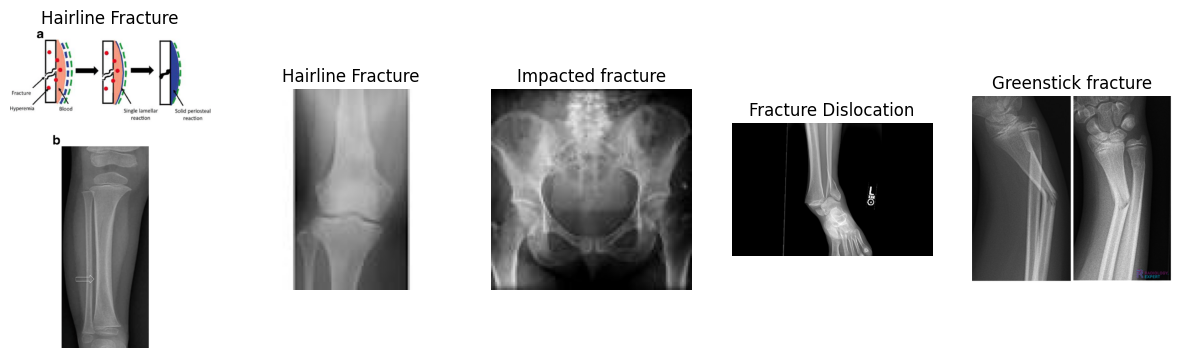

In [ ]:

import matplotlib.pyplot as plt
import random

dataset_path = path

# Example usage with displaying images
image_paths = []
for class_name in os.listdir(dataset_path + "/train"):
    class_dir = os.path.join(dataset_path + "/train", class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, image_name))


# Select random images
num_images_to_display = 5
selected_images = random.sample(image_paths, num_images_to_display)

# Display images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis ticks and labels
    axes[i].set_title(os.path.basename(os.path.dirname(image_path))) # Set title with the class name
plt.show()


# Define the Model

In [ ]:
from torchvision.models import efficientnet_v2_m

def create_model(num_classes=12):
    model = efficientnet_v2_m(pretrained=True)
    # Modify the classifier to match the number of classes in the dataset
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    return model


# Training and Validation Loops

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_val_loop(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        # Training loop, updates weights
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        train_loop = tqdm(train_loader, leave=True)  # Use tqdm for progress bar
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backpropagation
            optimizer.step() # Update model weights

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            train_loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            train_loop.set_postfix(loss=loss.item()) # Update progress bar postfix with loss

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_predictions / total_samples

        # Validation loop, no weight updates
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")


# Running Training


In [ ]:
# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip some images
    transforms.RandomRotation(10),  # Add data augmentation
    transforms.ToTensor(), # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Just resizing, no other changes for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Same normalization
])

# Create datasets
train_dataset = BoneFractureDataset(root_dir=os.path.join(dataset_path, "train"), class_to_idx=class_to_idx, transform=train_transform)
val_dataset = BoneFractureDataset(root_dir=os.path.join(dataset_path, "test"), class_to_idx=class_to_idx, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # don't shuffle in validation

# Quick check to see if the dataset loaded correctly
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")



Train Samples: 1170
Validation Samples: 515


In [10]:
# Create model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_classes=len(class_to_idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Train and validate the model
train_val_loop(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 225MB/s]
Epoch [1/10]:  38%|███▊      | 14/37 [00:10<00:18,  1.26it/s, loss=2.43]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images

Epoch [1/10], Train Loss: 2.4065, Train Acc: 17.35%, Val Loss: 2.1841, Val Acc: 24.47%


Epoch [2/10]: 100%|██████████| 37/37 [00:22<00:00,  1.63it/s, loss=1.57]


Epoch [2/10], Train Loss: 1.8796, Train Acc: 39.83%, Val Loss: 1.9725, Val Acc: 32.04%


Epoch [3/10]: 100%|██████████| 37/37 [00:22<00:00,  1.63it/s, loss=1.52]


Epoch [3/10], Train Loss: 1.3810, Train Acc: 55.30%, Val Loss: 1.8057, Val Acc: 42.91%


Epoch [4/10]: 100%|██████████| 37/37 [00:22<00:00,  1.62it/s, loss=1.22]


Epoch [4/10], Train Loss: 0.9572, Train Acc: 69.32%, Val Loss: 1.7750, Val Acc: 48.35%


Epoch [5/10]: 100%|██████████| 37/37 [00:22<00:00,  1.63it/s, loss=0.85]


Epoch [5/10], Train Loss: 0.7017, Train Acc: 78.72%, Val Loss: 1.7636, Val Acc: 48.54%


Epoch [6/10]: 100%|██████████| 37/37 [00:22<00:00,  1.62it/s, loss=0.329]


Epoch [6/10], Train Loss: 0.5228, Train Acc: 83.85%, Val Loss: 1.8854, Val Acc: 47.57%


Epoch [7/10]: 100%|██████████| 37/37 [00:22<00:00,  1.62it/s, loss=0.758]


Epoch [7/10], Train Loss: 0.4850, Train Acc: 85.38%, Val Loss: 2.0623, Val Acc: 48.16%


Epoch [8/10]: 100%|██████████| 37/37 [00:22<00:00,  1.62it/s, loss=0.41]


Epoch [8/10], Train Loss: 0.4171, Train Acc: 86.15%, Val Loss: 2.0582, Val Acc: 50.49%


Epoch [9/10]: 100%|██████████| 37/37 [00:22<00:00,  1.63it/s, loss=0.752]


Epoch [9/10], Train Loss: 0.3638, Train Acc: 87.61%, Val Loss: 2.0551, Val Acc: 50.49%


Epoch [10/10]: 100%|██████████| 37/37 [00:22<00:00,  1.64it/s, loss=0.668]


Epoch [10/10], Train Loss: 0.3687, Train Acc: 86.32%, Val Loss: 1.9647, Val Acc: 50.29%
